Electricity_Load_Forecasting using 'Feed Forward Neural Network' for '07-12-2020' to '20-12-2020'

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

print(tf.__version__)


2.4.0


In [45]:
from google.colab import drive
drive.mount('/content/drive')
Dataset = pd.read_excel("/content/drive/MyDrive/Colab_files/Train_20201207.xlsx")
Dataset.to_csv('train_20201102.csv')
Dataset.head()

# We copy the dataset such that we do not loose the original dataset
Original_Dataset = Dataset.copy()
Original_Dataset.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,Date,NEM Demand(Actual)
0,00:30,2020-12-07,5484.1
1,01:00,2020-12-07,5366.4
2,01:30,2020-12-07,5282.0
3,02:00,2020-12-07,5201.6
4,02:30,2020-12-07,5155.9


In [46]:
Dataset ['DateTime'] = Dataset['Date'].astype(str) + " "+ Dataset['Time'].astype(str)
Dataset.tail()
Dataset ['Date'] = pd.to_datetime(Dataset['Date'], format = '%Y-%m-%d')
Dataset.tail()
Dataset ['DateTime'] = pd.to_datetime(Dataset['DateTime'], format = '%Y-%m-%d %H:%M:%S')
Dataset.tail()
Dataset.dtypes
Dataset['DateTime'].iloc[453:]


453   2020-12-16 11:00:00
454   2020-12-16 11:30:00
455   2020-12-16 12:00:00
456   2020-12-16 12:30:00
457   2020-12-16 13:00:00
              ...        
667   2020-12-20 22:00:00
668   2020-12-20 22:30:00
669   2020-12-20 23:00:00
670   2020-12-20 23:30:00
671   2020-12-20 00:00:00
Name: DateTime, Length: 219, dtype: datetime64[ns]

DateTime
2020-12-07 00:30:00    5484.1
2020-12-07 01:00:00    5366.4
2020-12-07 01:30:00    5282.0
2020-12-07 02:00:00    5201.6
2020-12-07 02:30:00    5155.9
Name: NEM Demand(Actual), dtype: float64


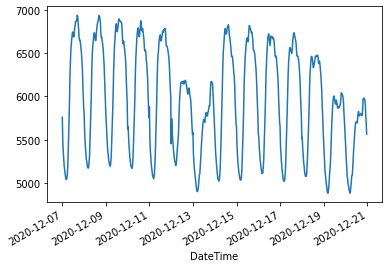

In [47]:
#Plot the dataset
plot_features = Dataset['NEM Demand(Actual)']
plot_features.index = Dataset['DateTime']
_= plot_features.plot(subplots = True)
print(plot_features.head())

In [48]:
Dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NEM Demand(Actual),672.0,5971.323661,609.974163,4877.7,5383.2,5980.1,6554.125,6942.8


In [49]:
cols = ['NEM Demand(Actual)']
Dataset_actual = Dataset[cols]
print(Dataset_actual.dtypes)
print(Dataset_actual.shape)
print(Dataset_actual.head())

NEM Demand(Actual)    float64
dtype: object
(672, 1)
   NEM Demand(Actual)
0              5484.1
1              5366.4
2              5282.0
3              5201.6
4              5155.9


In [50]:
Dataset_actual = Dataset_actual.values
Dataset_actual = Dataset_actual.astype('float32')
Dataset_actual.shape

(672, 1)

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
Dataset_actual = scaler.fit_transform(Dataset_actual)

In [52]:
train_size = int(len(Dataset_actual) * 0.66)
test_size = len(Dataset_actual) - train_size
train, test = Dataset_actual[0:train_size,:], Dataset_actual[train_size:len(Dataset_actual),:]


In [53]:
def to_sequences(Dataset_actual, seq_size=1):
    x = []
    y = []

    for i in range(len(Dataset_actual)-seq_size-1):
        #print(i)
        window = Dataset_actual[i:(i+seq_size), 0]
        x.append(window)
        y.append(Dataset_actual[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [54]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

print(trainX)

Shape of training set: (432, 10)
Shape of test set: (218, 10)
[[0.29364204 0.23664713 0.19577742 ... 0.08048034 0.07670331 0.08527422]
 [0.23664713 0.19577742 0.15684462 ... 0.07670331 0.08527422 0.10822725]
 [0.19577742 0.15684462 0.13471484 ... 0.08527422 0.10822725 0.14803147]
 ...
 [0.50462437 0.44404626 0.3747518  ... 0.16754627 0.1421721  0.12590194]
 [0.44404626 0.3747518  0.32003284 ... 0.1421721  0.12590194 0.11137486]
 [0.3747518  0.32003284 0.26696038 ... 0.12590194 0.11137486 0.11689496]]


In [55]:
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) 
model.add(Dense(64, activation='relu'))  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary()) 


Build deep model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=1, mode='auto', restore_best_weights=True)
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=25, callbacks = monitor)

Epoch 1/25
14/14 - 0s - loss: 0.1638 - val_loss: 0.0314
Epoch 2/25
14/14 - 0s - loss: 0.0356 - val_loss: 0.0111
Epoch 3/25
14/14 - 0s - loss: 0.0099 - val_loss: 0.0034
Epoch 4/25
14/14 - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 5/25
14/14 - 0s - loss: 0.0022 - val_loss: 0.0021
Epoch 6/25
14/14 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 7/25
14/14 - 0s - loss: 0.0012 - val_loss: 0.0017
Epoch 8/25
14/14 - 0s - loss: 0.0011 - val_loss: 0.0015
Epoch 9/25
14/14 - 0s - loss: 9.7840e-04 - val_loss: 0.0017
Epoch 10/25
14/14 - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 11/25
14/14 - 0s - loss: 8.3745e-04 - val_loss: 0.0012
Epoch 12/25
14/14 - 0s - loss: 7.9704e-04 - val_loss: 0.0010
Epoch 13/25
14/14 - 0s - loss: 7.7378e-04 - val_loss: 0.0012
Epoch 14/25
14/14 - 0s - loss: 7.6898e-04 - val_loss: 9.5552e-04
Epoch 15/25
14/14 - 0s - loss: 7.1011e-04 - val_loss: 0.0010
Epoch 16/25
14/14 - 0s - loss: 6.7762e-04 - val_loss: 7.9398e-04
Epoch 17/25
14/14 - 0s - loss: 7.2674e-04 - val_loss: 0.0011


In [57]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict.shape)

(432, 1)


In [58]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



In [59]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 47.33 RMSE
Test Score: 54.34 RMSE


In [60]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(Dataset_actual)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(Dataset_actual)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(Dataset_actual)-1, :] = testPredict


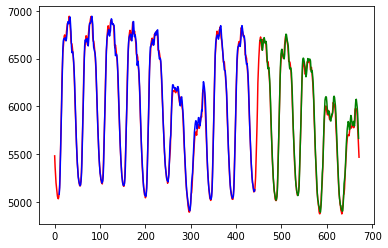

In [61]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(Dataset_actual), color= 'red', label = 'Original')
plt.plot(trainPredictPlot, color = 'blue', label = 'Prediction_on_traindataset')
plt.plot(testPredictPlot, color = 'green', label = 'Prediction_on_testdataset')
plt.show()


In [62]:
test = scaler.inverse_transform(test)

In [63]:
testp= np.empty_like(Dataset_actual)
testp[:, :] = np.nan
testp[len(trainPredict)+(seq_size*2)+1:len(Dataset_actual)-1, :] = test[11:]

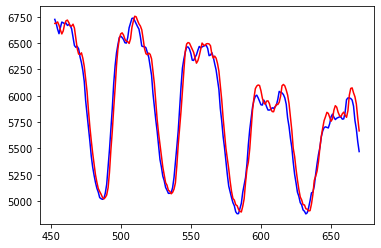

In [64]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(Dataset_actual), color= 'red', label = 'Original')
plt.plot(testp, color = 'blue', label = 'test_dataset')
#plt.plot(trainPredictPlot, color = 'blue', label = 'Prediction_on_traindataset')
plt.plot(testPredictPlot, color = 'red', label = 'Prediction_on_testdataset')
plt.show()
